# Tarea

Utilizando la encuesta CASEN 2017 o 2021 (en pandemia) realizar lo siguiente:
- Selección de una variable dependiente (puede ser salario).
- Selección de al menos 5 variables independientes.
- Análisis exploratorio de datos (EDA).
- Análisis de correlación.  

Modelo de Regresión Lineal Múltiple utilizando la librería STATSMODEL de Python.
- Comprobar los supuestos del análisis de Regresión Lineal (señalar si los supuestos son válidos o no).
- Interpretar el modelo de Regresión Lineal con sus respectivos coeficientes.  

Modelo de Regresión Lineal Múltiple utilizando la librería Scikit-learn de Python (con las mismas variables anteriormente utilizadas)
- Dividir la base de datos en “Entrenamiento” y “Test”.
- Comparar 30 predicciones con su valor real y mostrarlos en una tabla.
- Interpretar el modelo de Regresión Lineal con sus respectivos coeficientes.  

Calcular el error de tes - MSE (mean squared error) de ambos modelos creados y comparar cual de los modelos tiene el MSE más bajo.

------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels.stats.api as sms
import pylab 
import scipy.stats as stats 
import sklearn.metrics as metrics

from sklearn.metrics.pairwise import pairwise_distances
from statsmodels.tools.eval_measures import mse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


## CASEN 2020

------

Utilizaré la encuesta CASEN 2020 en pandemia, ya que la 2021 aún no está disponible.

------

In [2]:
df_casen_2020 = pd.read_spss('Casen en Pandemia 2020 SPSS.sav')

------

Para facilitar un primer vistazo de la información, transformaremos folio, o, id_vivienda e id_persona a entero, lo que nos entrega la llave única de cada registro.

------

In [3]:
df_casen_2020 = df_casen_2020.astype({'folio':'int','o':'int','id_vivienda':'int','id_persona':'int'})
df_casen_2020.head()

,folio,o,id_persona,id_vivienda,region,provincia,comuna,zona,area,segmento,...,v27,v28,v29,hacinamiento,nhog_viv,indsan,ten_viv,ten_viv_f,iae,iai
0,110110010101,1,5,1101100101,Región de Tarapacá,Iquique,Iquique,Urbano,Urbano,11011001.0,...,1,NaN,NaN,"Sin hacinamiento (menos de 2,5 personas por do...",1.0,Deficitario,Arrendada,Tenencia informal,Sin allegamiento externo,sin allegamiento interno
1,110110010101,2,6,1101100101,Región de Tarapacá,Iquique,Iquique,Urbano,Urbano,11011001.0,...,1,NaN,NaN,"Sin hacinamiento (menos de 2,5 personas por do...",1.0,Deficitario,Arrendada,Tenencia informal,Sin allegamiento externo,sin allegamiento interno
2,110110010201,2,31,1101100102,Región de Tarapacá,Iquique,Iquique,Urbano,Urbano,11011001.0,...,1,NaN,NaN,"Hacinamiento medio (entre 2,5 y 3,49 personas ...",1.0,Aceptable,Arrendada,Tenencia formal,Sin allegamiento externo,sin allegamiento interno
3,110110010201,1,32,1101100102,Región de Tarapacá,Iquique,Iquique,Urbano,Urbano,11011001.0,...,1,NaN,NaN,"Hacinamiento medio (entre 2,5 y 3,49 personas ...",1.0,Aceptable,Arrendada,Tenencia formal,Sin allegamiento externo,sin allegamiento interno
4,110110010201,3,30,1101100102,Región de Tarapacá,Iquique,Iquique,Urbano,Urbano,11011001.0,...,1,NaN,NaN,"Hacinamiento medio (entre 2,5 y 3,49 personas ...",1.0,Aceptable,Arrendada,Tenencia formal,Sin allegamiento externo,sin allegamiento interno


In [4]:
df_casen_2020.shape

(185437, 650)

## Variables utilizadas

------

Antes de cualquier limpieza nos damos cuentas que tenemos 650 campos y 185.473 registros. Para el desarrollo de la regresión utilizaremos las siguientes variables:
 - **Llave única**:
     - *folio*: Identificación del hogar.
     - *o*: Número de orden de la persona dentro del hogar.
     - *id_vivienda*: Identificador de la vivienda.
     - *id_persona*: Identificador de persona en el hogar.  
       
     
 - **Variable Dependiente**:
     - *y1*: Mes pasado, monto sueldo o salario líquido en su trabajo principal. (Variable continua)  
       
       
 - **Variables Independiente**:
     - *zona*: Zonda de la vivienda. (Variable categórica)
     - *e6a*: ¿Cuál es el nivel más alto alcanzado o el nivel educacional actual? (Variable ordinal)
     - *oficio1_08*: Oficio de la persona entrevistada (Variable Categórica)
     - *s13*: ¿A qué sistema previsional de salud pertenece usted? (Variable categórica)
     - *v1*: ¿Cuál es el tipo de vivienda en el que usted reside? (Variable categórica)  
       
       
El objetivo de este notebook es poder estimar el salario líquido de una persona en base a 5 variables (4 de ellas categórica y 1 de ellas ordinal), utilizando 2 módulos de Python diferentes. Posteriormente se compararan las estimaciones de los dos modelos en base a una medida de performance (MSE).  
  
Antes de comenzar con el modelamiento, se realiza un EDA para limpiar nuestra base de datos.

------

In [5]:
unique_key = ['folio', 'o', 'id_vivienda', 'id_persona']
dep_var = ['y1']
indep_var = ['zona','e6a','oficio1_08','s13','v1']
var = ['folio', 'o', 'id_vivienda', 'id_persona','zona','e6a','oficio1_08','s13','v1','y1']

df_var = df_casen_2020[var].rename(columns = {'e6a': 'educacion_maxima', 'oficio1_08': 'oficio', 's13': 'sistema_salud', 'v1': 'tipo_vivienda', 'y1': 'salario' }, inplace = False)
df_var

,folio,o,id_vivienda,id_persona,zona,educacion_maxima,oficio,sistema_salud,tipo_vivienda,salario
0,110110010101,1,1101100101,5,Urbano,Educación Media Científico-Humanista,Trabajadores de los servicios y vendedores de ...,ISAPRE,"Pieza en casa antigua, en conventillo, en galp...",NaN
1,110110010101,2,1101100101,6,Urbano,Educación Especial (Diferencial),NaN,ISAPRE,"Pieza en casa antigua, en conventillo, en galp...",NaN
2,110110010201,2,1101100102,31,Urbano,Educación Básica,NaN,Ninguno (particular),Departamento,NaN
3,110110010201,1,1101100102,32,Urbano,Técnico Nivel Superior Incompleto (Carreras 1 ...,Trabajadores de los servicios y vendedores de ...,Sistema Público FONASA,Departamento,372000.0
4,110110010201,3,1101100102,30,Urbano,Técnico Nivel Superior Incompleto (Carreras 1 ...,Artesanos y operarios de oficios,Ninguno (particular),Departamento,NaN
...,...,...,...,...,...,...,...,...,...,...
185432,1630530031401,1,16305300314,494,Rural,Educación Básica,Ocupaciones elementales,Ninguno (particular),Casa,NaN
185433,1630530031401,2,16305300314,495,Rural,Nunca asistió,NaN,Ninguno (particular),Casa,NaN
185434,1630530031501,3,16305300315,98,Rural,Profesional Incompleto (Carreras 4 ó más años),NaN,Sistema Público FONASA,Casa,NaN
185435,1630530031501,1,16305300315,96,Rural,Profesional Completo (Carreras 4 ó más años),NaN,Sistema Público FONASA,Casa,NaN


## Limpieza

------

Para facilitar el análisis se toman dos decisiones de limpieza de datos antes de cualquier análisis gráfico:

1. Se eliminan todos los valores nulos de nuestra base de datos para que tengamos completitud en todas las celdas.
2. Se le aplica logaritmo natural a la columna salario para que los outliers no afecten tanto nuestros modelos.

------

In [6]:
df_not_nan = df_var.dropna().reset_index(drop=True)
df_not_nan["salario"] = np.log2(df_not_nan['salario'])

In [7]:
list(df_not_nan['educacion_maxima'].unique())

['Técnico Nivel Superior Incompleto (Carreras 1 a 3 años)',
 'Técnico Nivel Superior Completo (Carreras 1 a 3 años)',
 'Profesional Incompleto (Carreras 4 ó más años)',
 'Educación Media Científico-Humanista',
 'Profesional Completo (Carreras 4 ó más años)',
 'Educación Media Técnica Profesional',
 'Postgrado Incompleto',
 'Educación Básica',
 'Humanidades (Sistema Antiguo)',
 'Postgrado Completo',
 'Técnica Comercial, Industrial o Normalista (Sistema Antiguo)',
 'Primaria o Preparatoria (Sistema antiguo)',
 'Nunca asistió',
 'Prekínder / Kínder (Transición menor y Transición Mayor)',
 'Educación Especial (Diferencial)']

------

Dado que existe una especie de orden en la variable de educación máxima (Por esto la taggeamos como ordinal) se realiza un parseo de esta a sus valores, dejando como valor 999 la Educación Especial. Todo esto para quitar los registros que tengan Educación Especial como valor de educación, y que nuestra ordinalidad tenga sentido.

------

In [8]:
def education_parse(level):
    aux_dict = {
        'Nunca asistió'                                                 : 1,
        'Sala cuna'                                                     : 2,
        'Jardín Infantil (Medio menor y Medio mayor)'                   : 3,
        'Prekínder / Kínder (Transición menor y Transición Mayor)'      : 4,
        'Primaria o Preparatoria (Sistema antiguo)'                     : 5,
        'Educación Básica'                                              : 6,
        'Humanidades (Sistema Antiguo)'                                 : 7,
        'Educación Media Científico-Humanista'                          : 8,
        'Técnica Comercial, Industrial o Normalista (Sistema Antiguo)'  : 9,
        'Educación Media Técnica Profesional'                           : 10,
        'Técnico Nivel Superior Incompleto (Carreras 1 a 3 años)'       : 11,
        'Técnico Nivel Superior Completo (Carreras 1 a 3 años)'         : 12,
        'Profesional Incompleto (Carreras 4 ó más años)'                : 13,
        'Profesional Completo (Carreras 4 ó más años)'                  : 14,
        'Postgrado Incompleto'                                          : 15,
        'Postgrado Completo'                                            : 16,
        'Educación Especial (Diferencial)'                              : 999
    }
    return aux_dict[level]

In [9]:
df_not_nan['ordinal_education'] = df_not_nan['educacion_maxima'].apply(education_parse)
df_not_nan = df_not_nan[df_not_nan['ordinal_education']!=999]

## Análisis exploratorio

------

Teniendo ya nuestra base pseudo limpia de outliers y con cada campo ya a medio trabajar, procederemos a realizar boxplots de todas nuestras variables para analizar si existe algun patrón que podamos notar a simple vista. 

------

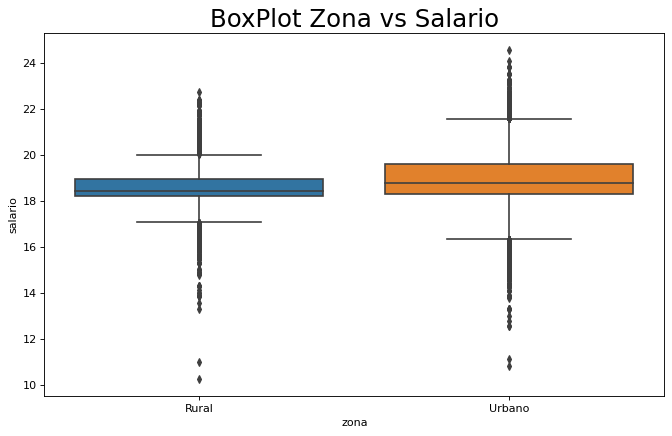

In [10]:
# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.boxplot(x='zona', y='salario', data=df_not_nan, notch=False)

# Add N Obs inside boxplot (optional)
def add_n_obs(df,group_col,y):
    medians_dict = {grp[0]:grp[1][y].median() for grp in df.groupby(group_col)}
    xticklabels = [x.get_text() for x in plt.gca().get_xticklabels()]
    n_obs = df.groupby(group_col)[y].size().values
    for (x, xticklabel), n_ob in zip(enumerate(xticklabels), n_obs):
        plt.text(x, medians_dict[xticklabel]*1.01, "#obs : "+str(n_ob), horizontalalignment='center', fontdict={'size':14}, color='white')

# Decoration
plt.title('BoxPlot Zona vs Salario', fontsize=22)
#plt.ylim(0, 2000000)
plt.show()

------

En primer lugar, notamos que la zona Urbana tiene un promedio mayor de salario que la zona rural, pero que también tiene una mayor varianza.

------

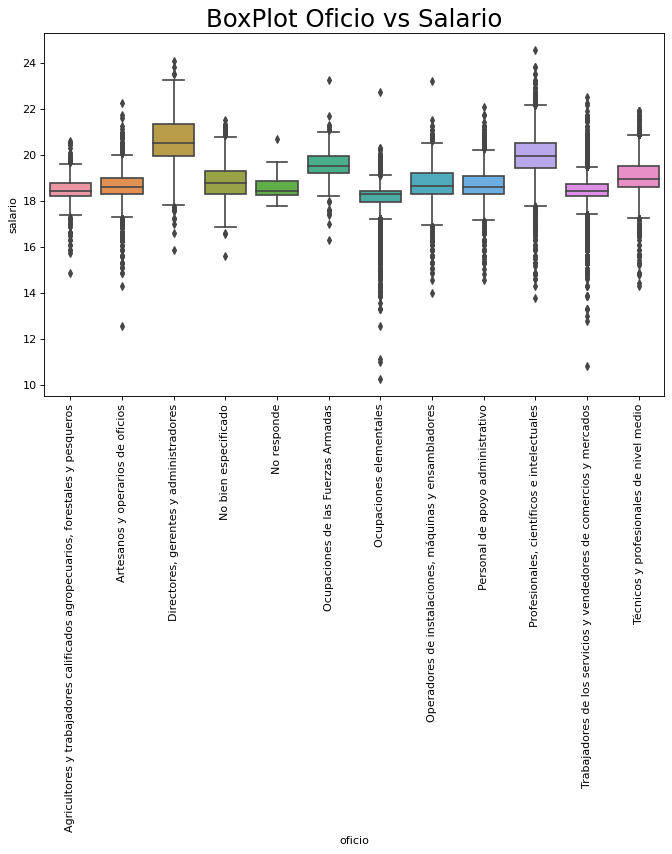

In [11]:
# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.boxplot(x='oficio', y='salario', data=df_not_nan, notch=False)

# Add N Obs inside boxplot (optional)
def add_n_obs(df,group_col,y):
    medians_dict = {grp[0]:grp[1][y].median() for grp in df.groupby(group_col)}
    xticklabels = [x.get_text() for x in plt.gca().get_xticklabels()]
    n_obs = df.groupby(group_col)[y].size().values
    for (x, xticklabel), n_ob in zip(enumerate(xticklabels), n_obs):
        plt.text(x, medians_dict[xticklabel]*1.01, "#obs : "+str(n_ob), horizontalalignment='center', fontdict={'size':14}, color='white')

# Decoration
plt.title('BoxPlot Oficio vs Salario', fontsize=22)
#plt.ylim(0, 5500000)
plt.xticks(rotation=90)
plt.show()

------

Del oficio es facil ver que los distintos oficios tienen muy distintos promedios de sueldo, siendo los que mayor salario ostentan los Directores, gerentes y administradores, junto con los Profesionales, cientificos e intelectuales. Entre los promedios de sueldo más bajos se encuentran quienes no respondieron a esta pregunta, junto con las Ocupaciones elementales, esto último a priori es algo preocupante, ya que tambien presentan una varianza muy alta con valores muy debajo de su 25% inferior.

------

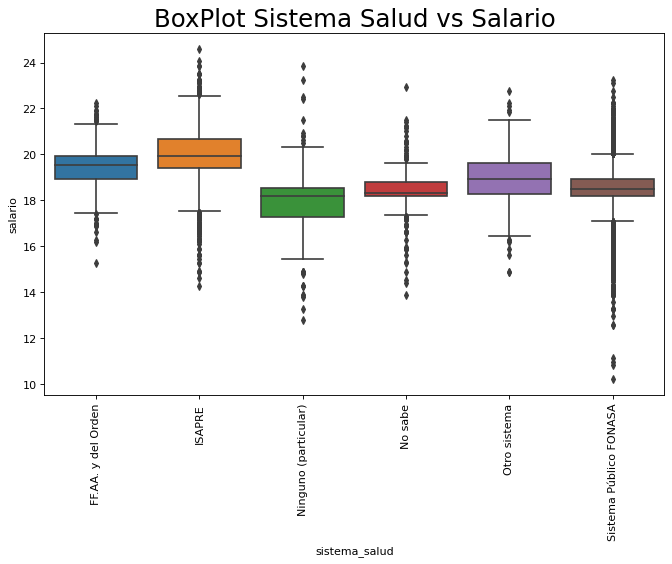

In [12]:
# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.boxplot(x='sistema_salud', y='salario', data=df_not_nan, notch=False)

# Add N Obs inside boxplot (optional)
def add_n_obs(df,group_col,y):
    medians_dict = {grp[0]:grp[1][y].median() for grp in df.groupby(group_col)}
    xticklabels = [x.get_text() for x in plt.gca().get_xticklabels()]
    n_obs = df.groupby(group_col)[y].size().values
    for (x, xticklabel), n_ob in zip(enumerate(xticklabels), n_obs):
        plt.text(x, medians_dict[xticklabel]*1.01, "#obs : "+str(n_ob), horizontalalignment='center', fontdict={'size':14}, color='white')

# Decoration
plt.title('BoxPlot Sistema Salud vs Salario', fontsize=22)
#plt.ylim(0, 3500000)
plt.xticks(rotation=90)
plt.show()

------

Del boxplot de sistema de salud se desprende lo esperable. Las personas con ISAPRE ostentan los salarios más altos, y las personas que no saben, no tienen o tienen FONASA se encuentran entre los salarios más bajos. Un dato importante es que las FF.AA y del Orden tienen muy poca varianza en sus salarios, con un salario promedio por sobre la mayoría de los demás sistemas de salud.

------

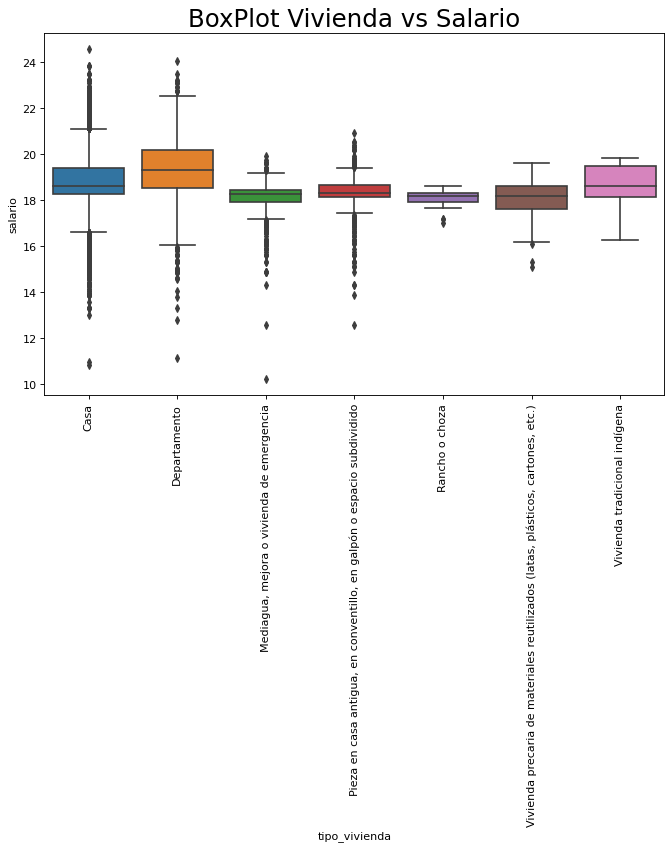

In [13]:
# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.boxplot(x='tipo_vivienda', y='salario', data=df_not_nan, notch=False)

# Add N Obs inside boxplot (optional)
def add_n_obs(df,group_col,y):
    medians_dict = {grp[0]:grp[1][y].median() for grp in df.groupby(group_col)}
    xticklabels = [x.get_text() for x in plt.gca().get_xticklabels()]
    n_obs = df.groupby(group_col)[y].size().values
    for (x, xticklabel), n_ob in zip(enumerate(xticklabels), n_obs):
        plt.text(x, medians_dict[xticklabel]*1.01, "#obs : "+str(n_ob), horizontalalignment='center', fontdict={'size':14}, color='white')

# Decoration
plt.title('BoxPlot Vivienda vs Salario', fontsize=22)
#plt.ylim(0, 2500000)
plt.xticks(rotation=90)
plt.show()

------

El boxplot que relacionaba tipo de vivienda con salario nos deja insigths interesantes, como por ejemplo casa, departamento y vivienda tradicional indigena tienen los salarios promedio más altos, teniendo el último mencionada una varianza baja en comparación a los dos primeros. El resto de los tipos de vivienda presenta relacion con un salario promedio más bien bajo, en donde rancho o choza presenta una varianza bajisima, dandonos a entender a priori que quizas todos quienes vivan bajo este tipo de vivienda tengan un estilo de vida similar.

------

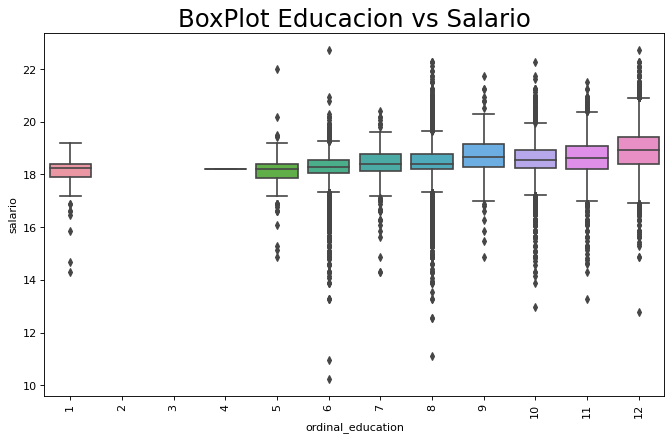

In [14]:
# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
sns.boxplot(x='ordinal_education', y='salario', data=df_not_nan, notch=False, order=[1,2,3,4,5,6,7,8,9,10,11,12])

# Add N Obs inside boxplot (optional)
def add_n_obs(df,group_col,y):
    medians_dict = {grp[0]:grp[1][y].median() for grp in df.groupby(group_col)}
    xticklabels = [x.get_text() for x in plt.gca().get_xticklabels()]
    n_obs = df.groupby(group_col)[y].size().values
    for (x, xticklabel), n_ob in zip(enumerate(xticklabels), n_obs):
        plt.text(x, medians_dict[xticklabel]*1.01, "#obs : "+str(n_ob), horizontalalignment='center', fontdict={'size':14}, color='white')

# Decoration
plt.title('BoxPlot Educacion vs Salario', fontsize=22)
#plt.ylim(0, 1300000)
plt.xticks(rotation=90)
plt.show()

------

Por último ocurre algo esperable, que es una relación lineal positiva entre mayor nivel educacional y mayor salario promedio. Cabe destacar que las mayores varianzas las presentan quienes terminaron educación básica y quienes terminaron una educación media científico-humanista como máximo nivel educacional.

------

Ahora, dado que las variables son categóricas, se realizará una obtención de variables binarias para cada valor, ya que así podemos realizar de manera correcta nuestra regresión utilizando variables categóricas transformadas

------

In [15]:
df_to_work = pd.get_dummies(df_not_nan, columns=["zona","educacion_maxima","oficio","sistema_salud","tipo_vivienda"])

------

Dado que casi todas nuestras variables son categóricas, no podemos obtener una correlación de Pearson o Spearman, no obstante podemos medir su similitud con alguna métrica de este estilo. Se utilizará la distancia de Jaccard (o Hamming) para ver la similitud entre todas las variables que tenemos luego de haber obtenido variables binarias para cada valor.

------

In [16]:
jac_df = df_to_work.drop(['folio','o','id_vivienda','id_persona','salario','ordinal_education'], axis='columns', inplace=False)
jac_sim = 1 - pairwise_distances(jac_df.T, metric = "hamming")
jac_sim = pd.DataFrame(jac_sim, index=jac_df.columns, columns=jac_df.columns)

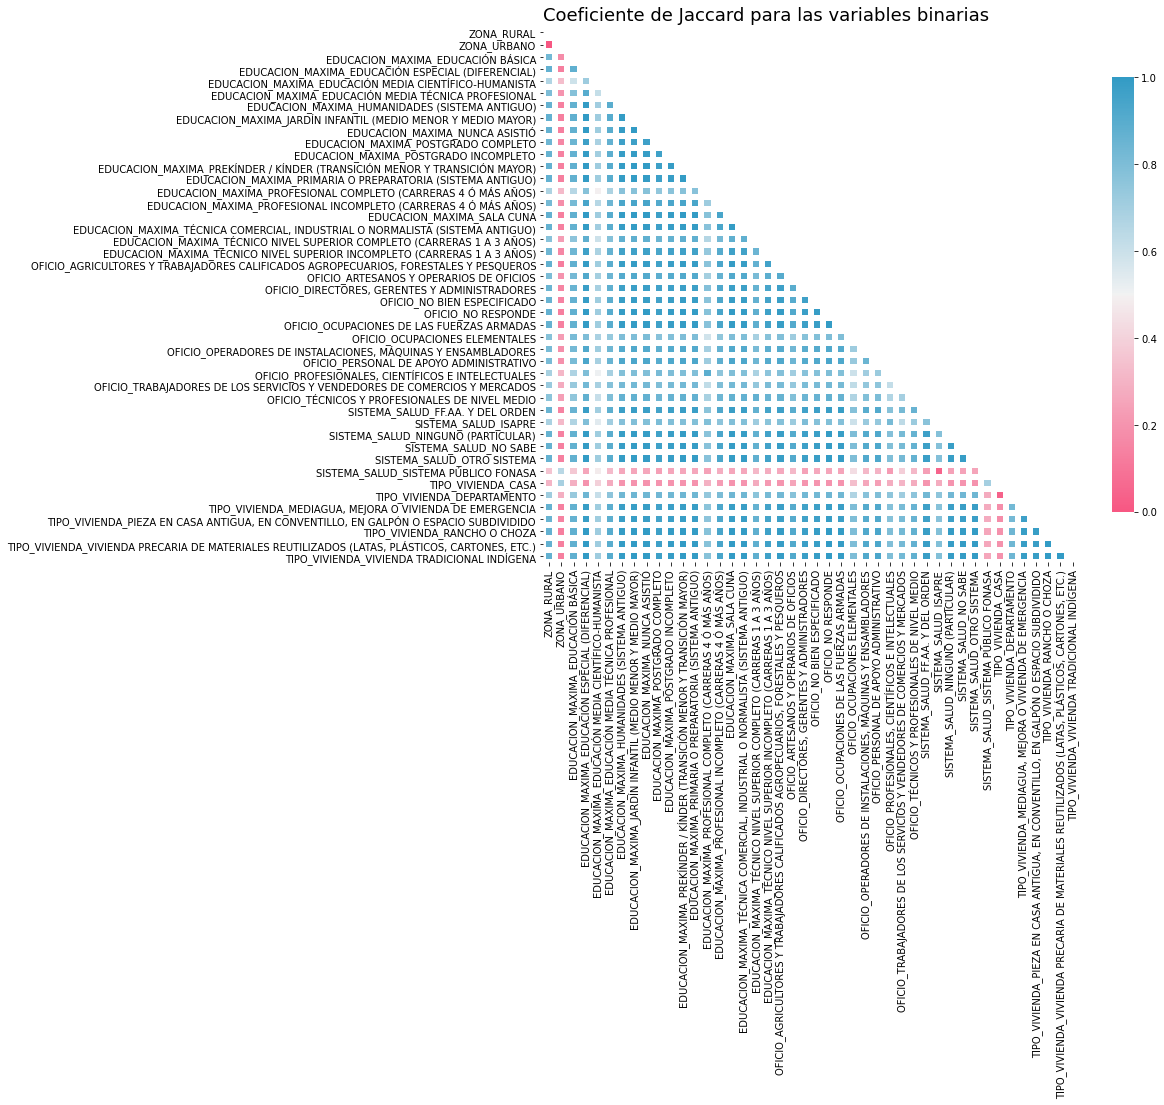

In [17]:
# HeatMap

fig, ax = plt.subplots(figsize=(12, 10))

mask = np.triu(np.ones_like(jac_sim, dtype=np.bool))

corr = jac_sim.copy()

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

sns.heatmap(corr, mask=mask, annot=False, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=0, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)

yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)

title = 'Coeficiente de Jaccard para las variables binarias'
plt.title(title, loc='left', fontsize=18)
plt.show()

------

Aquí se puede interpretar como variables muy correlacionadas las que tienen una similitud cercana a 0 o cercana a 1, ya que las cercanas a 0 quiere decir que se intersectan en muy pocos valores, y las cercanas a 1 que se intersectan en casi todos sus valores. Un claro ejemplo es la variable ZONA_RURAL con ZONA_URBANO, que tiene una similitud de 0, esperable ya que quienes viven en zona urbana no viven en zona rural, y viceversa. Un detalle relevante es que las personas que viven en zona rural tienen similitud con los sistemas de educación antiguo y con sistema de salud fonasa, a diferencia de los de zona urbana que tienen más similitud con sistemas de educación actuales y un equilibrio entre fonsa e isapre.

------  
  
Por último revisaremos como se comporta nuestra variable salario normalizada en términos de densidad.

/home/patricio/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


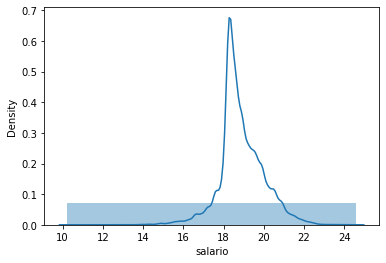

In [18]:
sns.distplot(df_not_nan['salario'], bins= 1)
plt.show()

------

Conformes con este análisis, procedemos a utilizar nuestros datos para los siguientes modelos de regresión.

------

## Supuestos del modelo de regresión

A continuación evaluaremos los supuestos del modelo de regresión

#### 1. Linealidad  
  
Primero dejamos un dataset listo para trabajarlo con la libreria statsmodel, la cual nos permite realizar una regresión de manera similar a como lo haríamos utilizando R. 

In [19]:
df_first_model = df_not_nan[["zona","educacion_maxima","oficio","sistema_salud","tipo_vivienda","salario","ordinal_education"]]
df_first_model.head()

,zona,educacion_maxima,oficio,sistema_salud,tipo_vivienda,salario,ordinal_education
0,Urbano,Técnico Nivel Superior Incompleto (Carreras 1 ...,Trabajadores de los servicios y vendedores de ...,Sistema Público FONASA,Departamento,18.504943,11
1,Urbano,Técnico Nivel Superior Completo (Carreras 1 a ...,Técnicos y profesionales de nivel medio,Otro sistema,Casa,21.516531,12
2,Urbano,Técnico Nivel Superior Incompleto (Carreras 1 ...,Trabajadores de los servicios y vendedores de ...,Sistema Público FONASA,Casa,18.287712,11
3,Urbano,Técnico Nivel Superior Incompleto (Carreras 1 ...,"Operadores de instalaciones, máquinas y ensamb...",Sistema Público FONASA,Casa,18.811274,11
4,Urbano,Profesional Incompleto (Carreras 4 ó más años),Ocupaciones elementales,Sistema Público FONASA,Casa,17.872675,13


In [20]:
formula = 'salario~C(zona)+C(educacion_maxima)+C(oficio)+C(sistema_salud)+C(sistema_salud)+C(tipo_vivienda)'
model_with_smf = smf.ols(formula=formula, data=df_first_model)
res = model_with_smf.fit()

------

El primer supuesto que comprobamos es la linealidad. Podemos verificar esto visualmente ajustando el modelo en los datos de entrenamiento y luego usándolo para predecir. Graficamos las predicciones frente a las reales y debemos observar que los puntos son aproximadamente simétricos alrededor de una línea que pasa por el origen con pendiente 1.

------

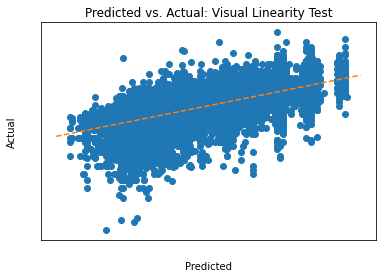

In [21]:
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    
    plt.plot(x_vals, y_vals, '--')

y_np = np.array(df_not_nan.salario)
y_hat = model_with_smf.predict(res.params)
plt.plot(y_hat,y_np,'o')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs. Actual: Visual Linearity Test')#,color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
abline(1,0)
plt.show()

Al parecer no tenemos una linealidad estricta a simple vista, solo una tendencia de linealidad con mucha varianza entre los datos reales y los predichos.

------

#### 2. Normalidad de los residuos  
  
Para probar la normalidad de los residuos, lo hacemos con una estimación de estos, ya que no conocemos los verdaderos términos de error. Primero hacemos un gráfico QQ, esto traza cuantiles teóricos de valores gaussianos frente a valores observados. Si los puntos se encuentran aproximadamente en la línea roja, entonces la gráfica es aproximadamente gaussiana.

------

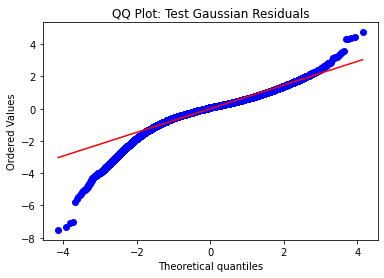

In [22]:
stats.probplot(y_np-y_hat, dist="norm", plot=pylab) 
pylab.title('QQ Plot: Test Gaussian Residuals') 
pylab.show()

------

A simple vista nos damos cuenta que las colas no estan sobre la linea y se alejan de manera, por lo cual es muy probable que nuestros residuso no distribuyan normalmente. Para confirmar esto utilizamos el test de Shapiro-Wilk, siendo la hipótesis nula que la población está distribuida normalmente.

------

In [23]:
shapiro_test = stats.shapiro(res.resid)
shapiro_test

/home/patricio/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9375365376472473, pvalue=0.0)

------

Dado que nuestro valor p es menor que 0.05, se rechaza la hipotesis nula por lo que no tenemos normalidad de los errores.

------

#### 3. Homocedasticidad
  
A continuación, verificamos si tenemos homocedasticidad (varianza igual en nuestros términos de error) o heterocedasticidad (varianza desigual).

------

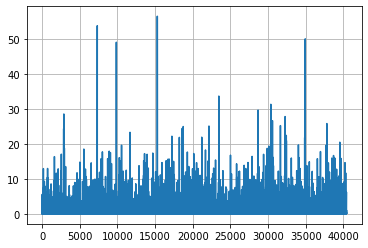

In [24]:
plt.plot(res.resid**2)
plt.grid(True)
plt.show()

In [25]:
breuschpagan_p= sms.het_breuschpagan(res.resid, res.model.exog)[1]
print(breuschpagan_p)
if breuschpagan_p> 0.05:
    print("La relación no es heterocedástica")
if breuschpagan_p <0.05:
    print("La relación es heterocedastica")

6.121389060559326e-91
La relación es heterocedastica


----

Nuevamente no se cumple nuestra hipótesis nula por lo que rechazamos el tener homocedasticidad.

----

### Modelo STATSModel

Veamos ahora los resultados de nuestro modelo

------

In [26]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                salario   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     1211.
Date:                Sun, 28 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:46:19   Log-Likelihood:                -46024.
No. Observations:               40391   AIC:                         9.212e+04
Df Residuals:                   40354   BIC:                         9.244e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

------

Dado este resultado, nos damos cuenta además que tenemos fuertes problemas de multicolinearidad, dado el pequeño valor propio de la matriz de covarianzas.  
  
También podemos observar que muchas de nuestras variables no son significativas, por lo que si quisieramos mejorar nuestro modelo de regresión, podríamos realizar alguna regularización o una eliminación de variables de acuerdo a su valor t.  
  
Por último, el R cuadrado es de 0.519, por lo que los datos estan en un porcentaje cercano al 52% ajustados a la regresión.
  
------

In [27]:
round(pd.DataFrame(res.params), 2).sort_values(0)

,0
C(sistema_salud)[T.Ninguno (particular)],-1.37
C(sistema_salud)[T.No sabe],-0.95
C(sistema_salud)[T.Sistema Público FONASA],-0.85
C(sistema_salud)[T.Otro sistema],-0.56
C(oficio)[T.Ocupaciones elementales],-0.38
C(educacion_maxima)[T.Prekínder / Kínder (Transición menor y Transición Mayor)],-0.36
"C(tipo_vivienda)[T.Vivienda precaria de materiales reutilizados (latas, plásticos, cartones, etc.)]",-0.25
"C(tipo_vivienda)[T.Mediagua, mejora o vivienda de emergencia]",-0.22
C(oficio)[T.Trabajadores de los servicios y vendedores de comercios y mercados],-0.20
C(tipo_vivienda)[T.Rancho o choza],-0.17


------

- Al ordenar los coeficientes obtenidos, nos damos cuenta de que el sistema de salud que mayor niveles de salario entregaría es ISAPRE. 
- También podemos apreciar que quienes estudiaron un postgrado (Ya sea completo o incompleto) y queienes estudiaron una carrera técnico o profesional tienen un mayor aumento de salario que personas que terminaron su enseñanza media como máximo nivel de estudios. 
- Cabe destacar que vivir en zona urbana aumenta el salario dado el coeficiente positivo, y que zona rural fue excluida dada su similitud 0 con zona urbana.
- Por último, algo que esperabamos desde el EDA es que Profesionales, científicos e intelectuales y Directores, gerentes y administradores son quienes ostentan los mayores coeficientes para esta regresión.

----

### Modelo Scikitlearn

----

Ahora para el modelo con la librería ScikitLearn, utilizaremos el dataframe ya trabajado a dummies y ordinal, y dividiremos este en conjuntos train y test, con una proporción de 80% y 20% respectivamente.

In [28]:
df_sk_regr = df_to_work.drop(['folio','o','id_vivienda','id_persona'], axis='columns', inplace=False)
X_sk = df_sk_regr.drop(['salario'], axis='columns', inplace=False).to_numpy()
y_sk = df_sk_regr.salario.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_sk, y_sk, test_size=0.2, random_state=0)

------

Con esto ya realizado podemos entrenar un modelo de regresión con esta librería.

------

In [29]:
model_with_skl = LinearRegression()
model_with_skl.fit(X_train, y_train)

LinearRegression()

In [30]:
print(model_with_skl.intercept_)

3263340405393.7754


In [31]:
print(model_with_skl.coef_)

[-1.14892774e+11 -2.29135990e+12 -2.29135990e+12 -2.69590042e+11
  1.94954337e+10 -3.98044933e+10  1.89981055e+11 -1.54697268e+11
  2.18096326e+09 -8.44053913e+11  8.79337701e+11  7.64444927e+11
 -4.99375590e+11 -3.84482816e+11  6.49552153e+11  5.34659378e+11
  7.29791367e+09  7.50882810e+10  4.19766604e+11  3.04873830e+11
 -1.70804381e+09 -1.70804381e+09 -1.70804381e+09 -1.70804381e+09
 -1.70804381e+09 -1.70804381e+09 -1.70804381e+09 -1.70804381e+09
 -1.70804381e+09 -1.70804381e+09 -1.70804381e+09 -1.70804381e+09
 -1.87020226e+10 -1.87020226e+10 -1.87020226e+10 -1.87020226e+10
 -1.87020226e+10 -1.87020226e+10  7.37624882e+09  7.37624882e+09
  7.37624882e+09  7.37624882e+09  7.37624882e+09  7.37624882e+09
  7.37624882e+09]


In [33]:
columns = np.asarray(list(df_sk_regr.drop(['salario'], axis='columns', inplace=False).columns))
coef = model_with_skl.coef_
df_coef_sk = pd.DataFrame({'columns':columns, 'coef':coef})
df_coef_sk.sort_values('coef')

,columns,coef
2,zona_Urbano,-2.291360e+12
1,zona_Rural,-2.291360e+12
9,educacion_maxima_Nunca asistió,-8.440539e+11
12,educacion_maxima_Prekínder / Kínder (Transició...,-4.993756e+11
13,educacion_maxima_Primaria o Preparatoria (Sist...,-3.844828e+11
3,educacion_maxima_Educación Básica,-2.695900e+11
7,educacion_maxima_Humanidades (Sistema Antiguo),-1.546973e+11
0,ordinal_education,-1.148928e+11
5,educacion_maxima_Educación Media Científico-Hu...,-3.980449e+10
34,sistema_salud_Ninguno (particular),-1.870202e+10


In [34]:
y_pred_skl = model_with_skl.predict(X_test)

In [35]:
def regression_results(y_true, y_pred):

    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [36]:
regression_results(y_hat,y_np)

explained_variance:  0.0743
mean_squared_log_error:  0.0015
MAE:  0.5358
MSE:  0.5718
RMSE:  0.7562


In [37]:
regression_results(y_test,y_pred_skl)

explained_variance:  0.5339
mean_squared_log_error:  0.0015
MAE:  0.5317
MSE:  0.5498
RMSE:  0.7415


------

Comparando nuestros valores, los dos modelos son similares, no obstante el segundo al parecer explica de mejor manera la varianza del conjunto de datos que el primero.

------